In [108]:
import numpy as np
from numpy.linalg import norm
from math import sin, cos, pi, asin, atan2, degrees, radians, acos
from tabulate import tabulate

np.set_printoptions(suppress=True,precision=11)

# 1. Rotations

In [4]:
def wedge(v):
    return np.matrix([[0, -v[2], v[1]],
                     [v[2], 0,  -v[0]],
                     [-v[1], v[0], 0]]);

def get_rotation_rodriguez(v, theta=None):
    if theta is None:
        theta = norm(v); 
        n = v/theta; 
    else: 
        n = v; 
        
    cM = wedge(n); 
    return np.identity(3) + sin(theta)*cM + (1-cos(theta))*cM*cM


## a

In [14]:
def rotx(phi):
    v = phi*np.array([1, 0, 0]); 
    return get_rotation_rodriguez(v)

def roty(theta):
    v = theta*np.array([0, 1, 0]); 
    return get_rotation_rodriguez(v)

def rotz(psi):
    v = psi*np.array([0, 0, 1]); 
    return get_rotation_rodriguez(v) 

def angles2rot(phi, theta, psi): 
    return rotz(psi)*roty(theta)*rotx(phi)

## b

In [16]:
print('R= \n' + str(angles2rot(phi=pi/4, theta=pi/5, psi=pi/7)))

R= 
[[ 0.72889912554  0.06766479742  0.68126906578]
 [ 0.35101931853  0.81741496597 -0.45674742629]
 [-0.58778525229  0.57206140282  0.57206140282]]


## c

In [17]:
def rot2angles(M):
    sin_theta = -M[2, 0];     
    theta = asin(sin_theta);     
    
    if sin_theta==1:
        psi = 0; # arbitrary
        phi = atan2(M[0,1],M[0,2]);     
    elif sin_theta==-1:
        psi = 0; # arbitrary
        phi = atan2(-M[0,1],-M[0,2]);        
    else:
        # another valid solution: pi-theta.             
        cos_theta = cos(theta); 
        phi = atan2(M[2,1]/cos_theta, M[2, 2]/cos_theta);
        psi = atan2(M[1,0]/cos_theta, M[0, 0]/cos_theta);
    
    return phi, theta, psi

## d

In [22]:
phi, theta, psi = (degrees(x) for x in rot2angles(
    np.mat(' 0.813797681 -0.440969611 0.378522306;  \
                           0.46984631   0.882564119 0.0180283112; \
                          -0.342020143  0.163175911 0.925416578')))
print('phi=' + str(phi), 'theta=' + str(theta), 'psi=' + str(psi))

phi=9.999999994217536 theta=19.999999980143038 psi=29.99999998990158


# 2. 3D Rigid Transformation

In [23]:
trans = np.mat([-451.2459, 257.0322, 400])
rot = np.mat('0.5363 -0.8440 0; 0.8440 0.5363 0; 0 0 1'); 

pt = np.mat([450, 400, 50])

Tgl = rot.dot((pt + trans).T)
print(Tgl)

[[-555.20335297]
 [ 351.31482926]
 [ 450.        ]]


# 3. Pose Composition
Commanded: 
\begin{gather}
x^c_{k+1} = x_k + \begin{pmatrix} 0 \\ 1 \end{pmatrix} \\
R^c_{k+1} = R^c_k
\end{gather}

Actual: 
\begin{gather}
x^a_{k+1} = x_k + \begin{pmatrix} 0 \\ 1.1 \end{pmatrix} \\
R^a_{k+1} = R(1) \cdot R^c_k
\end{gather}

In [5]:
M = np.mat('1 2; 3 4')
M[0,1]

2

Location difference: 0.793435624902 m
Orientation difference: 9.999999999999902°


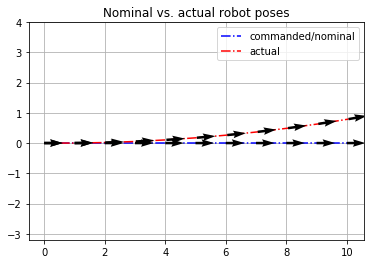

In [122]:
%matplotlib inline

import matplotlib.pyplot as plt
from copy import deepcopy 

def rotation2(theta): 
    return np.mat([[cos(theta),sin(theta)],
                [-sin(theta),cos(theta)]]); 

def rot2angle(R):
    return atan2(R[0, 1], R[1, 1]); 

Tc = np.concatenate((np.identity(2), np.mat([[1],[0]])), axis=1); 

dtheta = pi/180;
Ta = np.concatenate((rotation2(-dtheta), np.mat([[1.01],[0]])), axis=1); 

# Initial pose
origin = np.mat([[0,0]]).T;
orientation = np.mat([[1, 0]]).T; 
Ti = np.concatenate((np.identity(2), np.mat([[0],[0]])), axis=1); 

# Lists hold nominal and actual pose history
T1 = [{"T" : Ti, "origin" : origin, "orientation" : orientation}]; 
T2 = deepcopy(T1); 
for ii in range(10):
    # commanded
    Tk = Tc.dot(np.vstack((T1[-1]['T'], [0, 0, 1]))); 
    nominal_origin = Tk[:,-1]; 
    Rk = Tk[0:2,0:2]; 
    nominal_orientation = Rk.dot(orientation);    
    T1.append({"T" : Tk, "origin" : nominal_origin, "orientation" : nominal_orientation})
    
    # actual
    Tk = Ta.dot(np.vstack((T2[-1]['T'], [0, 0, 1]))); 
    actual_origin = Tk[:,-1]; 
    Rk = Tk[0:2,0:2]; 
    actual_orientation = Rk.dot(orientation);  
    T2.append({"T" : Tk, "origin" : actual_origin, "orientation" : actual_orientation})
    
def disp_track(locations, orientations, color='b'):
    x = [o[0].item(0) for o in locations]
    y = [o[1].item(0) for o in locations]
    u = [o[0].item(0) for o in orientations]
    v = [o[1].item(0) for o in orientations]
    plt.plot(x, y, '-.', color=color)
    plt.quiver(x, y, u, v, color='k',zorder=10)
    
plt.figure()

Pc = [P['origin'] for P in T1]
Uc = [P['orientation'] for P in T1]
disp_track(Pc, Uc)

Pa = [P['origin'] for P in T2]
Ua = [P['orientation'] for P in T2]
disp_track(Pa, Ua, 'r')

plt.grid(True)
plt.axis('equal'); 
plt.legend(['commanded/nominal', 'actual']); 
plt.title('Nominal vs. actual robot poses'); 

print('Location difference: ' + str(norm(Pc[-1]-Pa[-1])) + ' m')
print('Orientation difference: ' + str(degrees(acos(Ua[-1].T.dot(Uc[-1])))) + u'\N{DEGREE SIGN}')